<a href="https://colab.research.google.com/github/Asymptote07/EAuction-Website/blob/main/ANC_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using CPU for training.
137500/137500 ━━━━━━━━━━━━━━━━━━━━ 4786s 35ms/step - loss: 0.0103
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 100, 128)       │            512 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 100, 128)       │            512 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 100, 64)        │         24,640 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 50, 64)         │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 50, 64)         │          4,160 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 50, 64)         │          4,160 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 50, 64)         │          4,160 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 50, 64)         │              0 │ dense[0][0],           │
│                           │                        │                │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3200)           │              0 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │        102,432 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             33 │ dense_3[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 421,317 (1.61 MB)

 Trainable params: 140,353 (548.25 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 280,708 (1.07 MB)

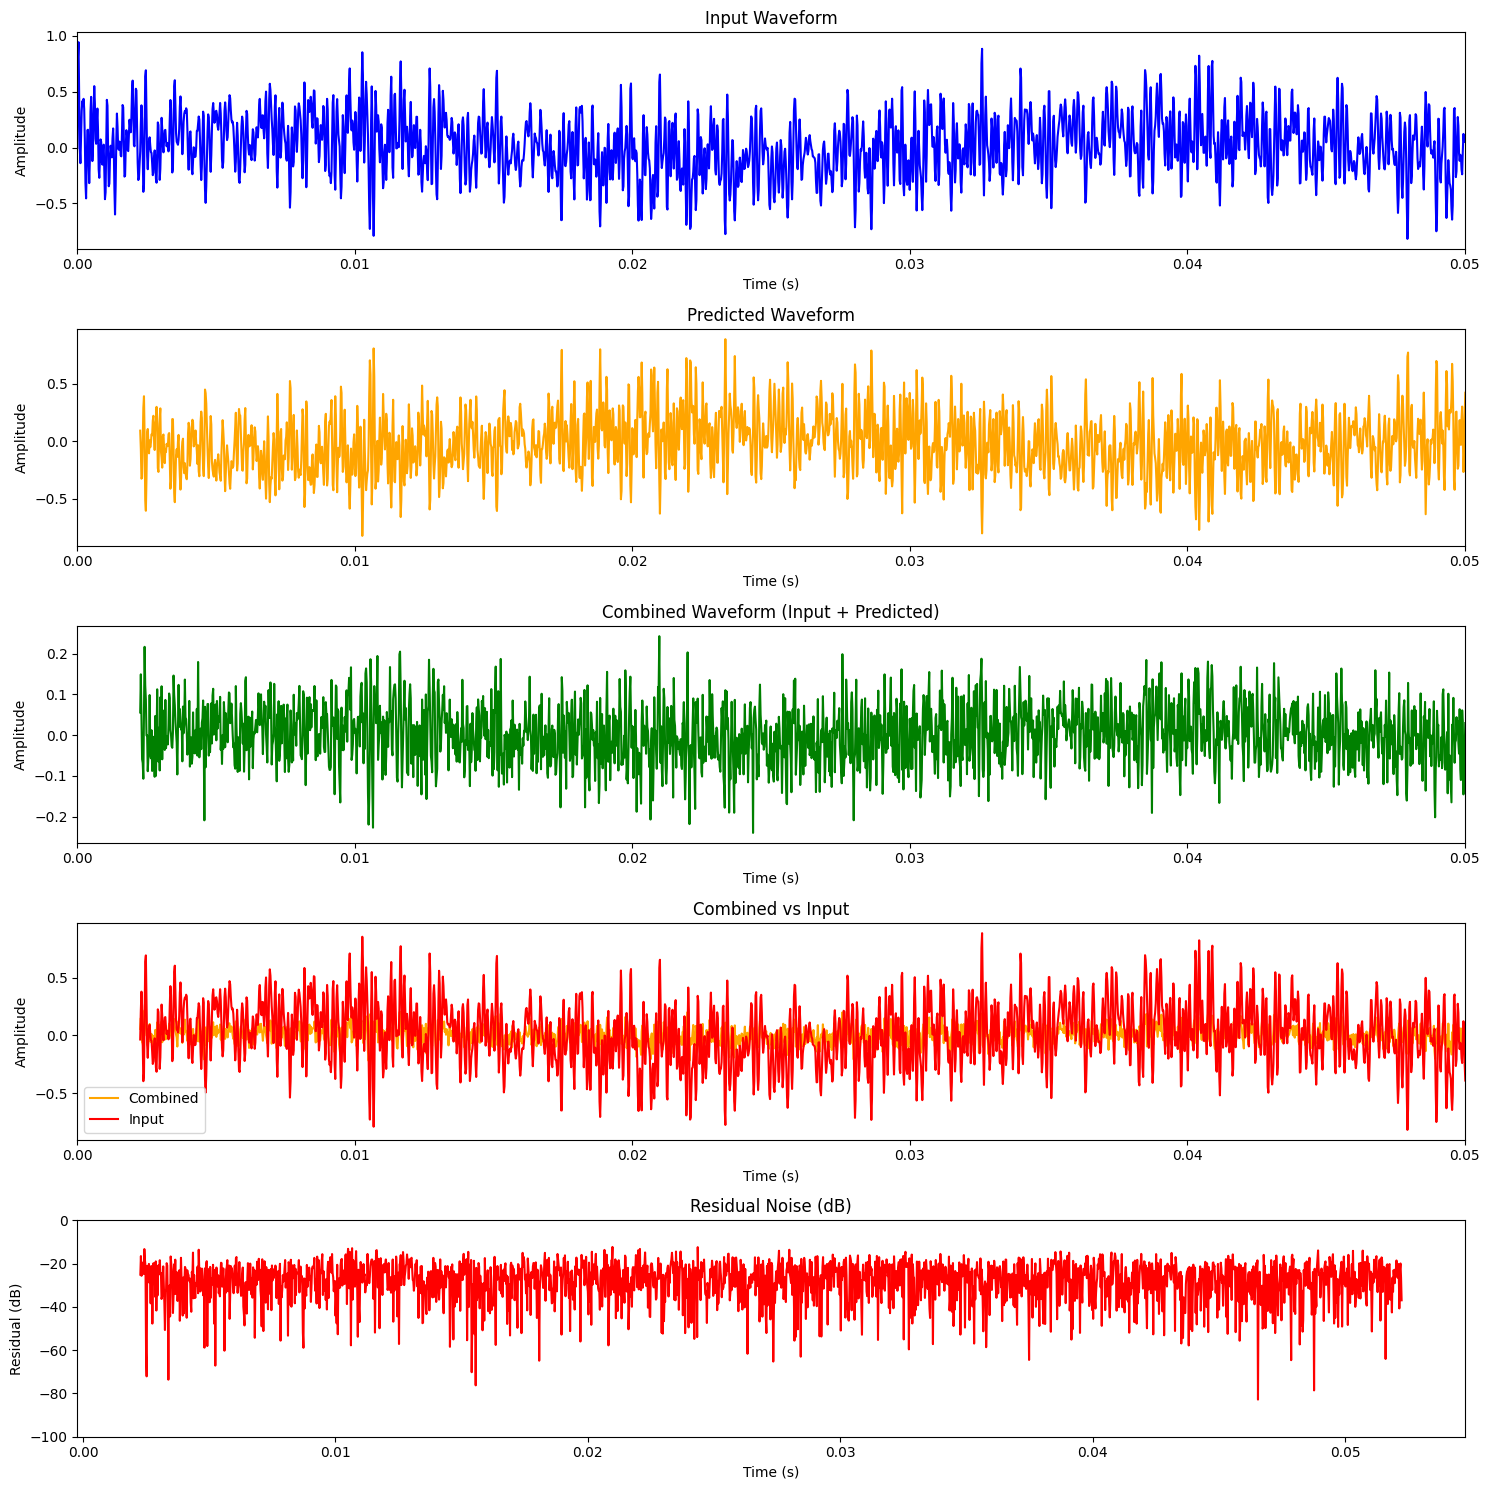

Test Input Waveform:


Predicted Inverted Waveform:


Combined Waveform:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

class WaveformPredictor:
    # Public parameters for easy tuning
    num_training_waves = 100  # Number of waves to use for training
    duration = 1.0           # Duration in seconds
    sample_rate = 44100      # Samples per second
    epochs = 1               # Number of training epochs
    learning_rate = 0.0001   # Learning rate for the optimizer
    sequence_length = 100     # Number of previous samples to consider for prediction
    max_freq = 10000         # Maximum frequency for urban noise generation
    batch_size = 32          # Batch size for training

    def __init__(self):
        self.model = self.build_model()
        self.device = self.set_device()

    def set_device(self):
        # Check if GPU is available and set the device accordingly
        if tf.config.list_physical_devices('GPU'):
            print("Using GPU for training.")
            return 'GPU'
        else:
            print("Using CPU for training.")
            return 'CPU'

    def generate_waveform(self):
        """
        Generate synthetic urban noise, such as machinery or engine sounds,
        using a mix of random sine waves and random noise components.
        """
        t = np.linspace(0, self.duration, int(self.sample_rate * self.duration), endpoint=False)

        # Define some random frequencies within the urban noise range
        frequencies = np.random.uniform(20, self.max_freq, size=np.random.randint(5, 20))
        waveform = np.zeros_like(t)

        # Create sine wave components to simulate machinery/engine harmonics
        for f in frequencies:
            amplitude = np.random.uniform(0.1, 0.5)  # Random amplitude for each component
            waveform += amplitude * np.sin(2 * np.pi * f * t)

        # Add random white noise to simulate the constant hum and environmental noise
        noise_amplitude = np.random.uniform(0.05, 0.1)
        noise = noise_amplitude * np.random.randn(len(t))
        waveform += noise

        return waveform / np.max(np.abs(waveform))  # Normalize to [-1, 1]

    def prepare_data(self):
        input_waveforms = np.array([self.generate_waveform() for _ in range(self.num_training_waves)])

        X, y = [], []
        for waveform in input_waveforms:
            for i in range(len(waveform) - self.sequence_length):
                X.append(waveform[i:i + self.sequence_length])
                y.append(-waveform[i + self.sequence_length])  # Predict the inverted phase

        X = np.array(X).reshape(-1, self.sequence_length, 1)
        y = np.array(y)
        return X, y

    def build_model(self):
        input_layer = layers.Input(shape=(self.sequence_length, 1))

        # Convolutional layers for feature extraction
        x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(input_layer)
        x = layers.BatchNormalization()(x)
        x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
        x = layers.MaxPooling1D(pool_size=2)(x)

        # Attention mechanism
        query = layers.Dense(64, activation='relu')(x)
        key = layers.Dense(64, activation='relu')(x)
        value = layers.Dense(64, activation='relu')(x)
        attention_output = layers.Attention()([query, key, value])

        # Flatten the output for dense layers
        flatten = layers.Flatten()(attention_output)
        dense = layers.Dense(32, activation='relu')(flatten)

        # Output layer for regression
        output = layers.Dense(1)(dense)

        model = models.Model(inputs=input_layer, outputs=output)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mean_squared_error')
        return model

    def train(self):
        X, y = self.prepare_data()
        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        history = self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=1, callbacks=[early_stopping])
        return history

    def predict(self, test_waveform):
        X_test = []
        for i in range(len(test_waveform) - self.sequence_length):
            X_test.append(test_waveform[i:i + self.sequence_length])
        X_test = np.array(X_test).reshape(len(X_test), self.sequence_length, 1)
        predicted_waveform = self.model.predict(X_test)
        return predicted_waveform.flatten()

    def plot_results(self, test_waveform, predicted_waveform, combined_waveform):
        time_axis = np.linspace(0, self.duration, int(self.sample_rate * self.duration), endpoint=False)

        plt.figure(figsize=(15, 15))

        # Zoom in on the first 50 ms
        zoom_duration = 0.05  # 50 ms
        zoom_samples = int(self.sample_rate * zoom_duration)

        # Plot original test waveform
        plt.subplot(5, 1, 1)
        plt.title('Input Waveform')
        plt.plot(time_axis[:zoom_samples], test_waveform[:zoom_samples], color='blue')
        plt.xlim(0, zoom_duration)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        # Plot predicted waveform
        plt.subplot(5, 1, 2)
        plt.title('Predicted Waveform')
        plt.plot(time_axis[self.sequence_length:self.sequence_length + zoom_samples], predicted_waveform[:zoom_samples], color='orange')
        plt.xlim(0, zoom_duration)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        # Plot combined waveform
        plt.subplot(5, 1, 3)
        plt.title('Combined Waveform (Input + Predicted)')
        plt.plot(time_axis[self.sequence_length:self.sequence_length + zoom_samples], combined_waveform[:zoom_samples], color='green')
        plt.xlim(0, zoom_duration)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        # Plot combined vs input
        plt.subplot(5, 1, 4)
        plt.title('Combined vs Input')
        plt.plot(time_axis[self.sequence_length:self.sequence_length + zoom_samples], combined_waveform[:zoom_samples], color='orange', label='Combined')
        plt.plot(time_axis[self.sequence_length:self.sequence_length + zoom_samples], test_waveform[self.sequence_length:self.sequence_length + zoom_samples], color='red', label='Input')
        plt.xlim(0, zoom_duration)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.legend()

        # Calculate residuals
        residuals = combined_waveform[:zoom_samples]
        residuals_db = 20 * np.log10(np.abs(residuals) + 1e-10)  # Adding a small value to avoid log(0)

        # Plot residual noise in dB
        plt.subplot(5, 1, 5)
        plt.title('Residual Noise (dB)')
        plt.plot(time_axis[self.sequence_length:self.sequence_length + zoom_samples], residuals_db, color='red')
        plt.xlabel('Time (s)')
        plt.ylabel('Residual (dB)')
        plt.ylim(-100, 0)  # Set limits for better visibility

        plt.tight_layout()
        plt.show()

    def model_summary(self):
        self.model.summary()

# Usage
predictor = WaveformPredictor()
history = predictor.train()

# Generate a new test waveform for prediction
test_waveform = predictor.generate_waveform()
predicted_waveform = predictor.predict(test_waveform)

# Calculate combined waveform
combined_waveform = test_waveform[predictor.sequence_length:] + predicted_waveform

# Show model summary
predictor.model_summary()

# Plot results
predictor.plot_results(test_waveform, predicted_waveform, combined_waveform)

# Provide audio playback
print("Test Input Waveform:")
display(Audio(test_waveform, rate=predictor.sample_rate))
print("Predicted Inverted Waveform:")
display(Audio(predicted_waveform, rate=predictor.sample_rate))
print("Combined Waveform:")
display(Audio(combined_waveform, rate=predictor.sample_rate))
